In [0]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib as mpl
import scipy
import scipy.io
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

from scipy import stats # to fit linear regression
from math import sqrt

%load_ext autoreload
%autoreload 2

In [0]:
""" The url must be set each time the data gets loaded from the data_train.csv file:
      Step 1 : Go to the github repository and click on the file (https://github.com/Anne-Aimee/recommender_system/blob/master/Datasets/data_train.csv)
      Step 2 : Click 'View Raw' and copy the url into the designated space below
"""
url = 'https://raw.githubusercontent.com/Anne-Aimee/recommender_system/master/Datasets/data_train.csv?token=ALBZK5HA42QTWNLFAFHISVK556QQQ'


In [12]:
# Load the ratings and convert it to a sparse matrix in coo format
import pandas as pd
df = pd.read_csv(url)
df['r'],df['c'] = df['Id'].str.split('_').str # Separate Id into r and c
df['r'] = df['r'].str.lstrip('r')
df['c'] = df['c'].str.lstrip('c')
row = df['c'].to_numpy().astype(int)
col = df['r'].to_numpy().astype(int)
data = df['Prediction'].to_numpy().astype(int)
ratings = sp.coo_matrix((data, (row-1, col-1)), shape=((row.max(), col.max())))
print("number of items : {}, number of ratings : {}".format(ratings.shape[0],ratings.shape[1]))

number of items : 1000, number of ratings : 10000


In [0]:
def plot_raw_data(ratings):
    """plot the statistics result on raw rating data."""
    # do statistics.
    num_items_per_user = np.array((ratings != 0).sum(axis=0)).flatten()
    num_users_per_item = np.array((ratings != 0).sum(axis=1).T).flatten()
    sorted_num_movies_per_user = np.sort(num_items_per_user)[::-1]
    sorted_num_users_per_movie = np.sort(num_users_per_item)[::-1]

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(sorted_num_movies_per_user, color='blue')
    ax1.set_xlabel("users")
    ax1.set_ylabel("number of ratings (sorted)")
    ax1.grid()

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(sorted_num_users_per_movie)
    ax2.set_xlabel("items")
    ax2.set_ylabel("number of ratings (sorted)")
    ax2.set_xticks(np.arange(0, 2000, 300))
    ax2.grid()

    plt.tight_layout()
    plt.savefig("stat_ratings")
    plt.show()
    # plt.close()
    return num_items_per_user, num_users_per_item

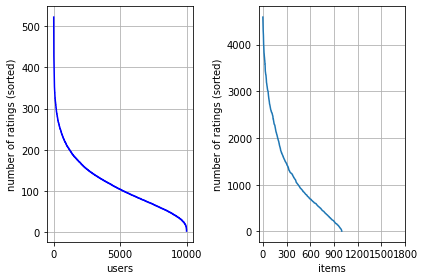

min # of items per user = 3, min # of users per item = 8.


In [14]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

In [0]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # split the data and return train and test data.
    # we only consider users and movies that have more than 10 ratings

    ind_test = np.random.choice(valid_ratings.nnz, int(valid_ratings.nnz*p_test), replace=False)
    ind_train = np.delete(np.arange(valid_ratings.nnz),ind_test)
    
    valid_ratings_coo = valid_ratings.tocoo()
    data = valid_ratings_coo.data
    row = valid_ratings_coo.row
    col = valid_ratings_coo.col
    
    test = sp.coo_matrix((data[ind_test], (row[ind_test], col[ind_test])), shape=valid_ratings.get_shape())
    train = sp.coo_matrix((data[ind_train], (row[ind_train], col[ind_train])), shape=valid_ratings.get_shape()) 
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [44]:
valid_ratings, train, test = split_data(
    ratings.tolil(), num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
#plot_train_test_data(train, test)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


In [45]:
class MyLinearRegression:
    def __init__(self, number_features):
        # TODO: Define the parameters of the model (weights and biases)

        self.user_features = Variable(torch.rand(number_features, train.shape[1]), requires_grad=True)
        self.item_features = Variable(torch.rand(number_features, train.shape[0]), requires_grad=True)
    
    def forward(self, d, n):
        # TODO: implement forward computation - compute predictions based on the inputs
        #return torch.mm( torch.transpose(self.item_features), self.user_features )
        #return torch.matmul(torch.t(self.user_features[:,n]), self.item_features[:,d])
        return torch.sum(self.user_features[:,n]*self.item_features[:,d], dim=0)
    
    def parameters(self):
        # TODO: this function should return a list of parameters of the model
        return self.user_features, self.item_features
    
    def __call__(self, d, n):
        # Convenience function
        return self.forward(d, n)
    

def mselossfunc(pred, ratings):
    # TODO: implement the MSE loss function
    return (pred - ratings).pow(2).mean()

model = MyLinearRegression(20)
numpy_ns = np.asarray([0, 1, 2], dtype = np.int64)
numpy_ds = np.asarray([0, 1, 2], dtype = np.int64)
torch_ns = Variable(torch.from_numpy(numpy_ns))
torch_ds = Variable(torch.from_numpy(numpy_ds))
torch_os = model(torch_ns, torch_ds)
print("Testing model: an input of %s gives a prediction:\n %s" % (numpy_ns, torch_os))

Testing model: an input of [0 1 2] gives a prediction:
 tensor([5.3790, 5.3678, 4.0027], grad_fn=<SumBackward1>)


In [0]:
def train_SGD(row, col, ratings, model, lossfunc, optimizer, num_epoch):

    for epoch in range(num_epoch):
        # TODO: Step 1 - create torch variables corresponding to features and labels
        row_torch = Variable(torch.from_numpy(row))
        col_torch = Variable(torch.from_numpy(col))

        targets = Variable(torch.from_numpy(ratings))

        # TODO: Step 2 - compute model predictions and loss
        outputs = model(row_torch, col_torch)
        loss = lossfunc(outputs, targets)
        
        # TODO: Step 3 - do a backward pass and a gradient update step
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epoch, loss.item()))
        
        
def visualize(x_train, y_train, model):
    # A convenience function for visualizing predictions given by the model

    predicted = model(Variable(torch.from_numpy(x_train))).data.numpy()
    order = np.argsort(x_train, axis = 0)
    plt.plot(x_train[order].flatten(), y_train[order].flatten(), 'ro', label='Original data')
    plt.plot(x_train[order].flatten(), predicted[order].flatten(), label='Fitted line')
    plt.legend()
    plt.show()

In [50]:
# Training and visualizing predictions made by linear regression model
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

train_SGD(row = train.row.astype('int64'),
      col = train.col.astype('int64'),
      ratings = train.data,
      model = model,
      lossfunc = mselossfunc, 
      optimizer = optimizer,
      num_epoch = 100)
#visualize(x_train, y_train, model)

Epoch [1/100], Loss: 3.5899
Epoch [11/100], Loss: 3.5892
Epoch [21/100], Loss: 3.5886
Epoch [31/100], Loss: 3.5880
Epoch [41/100], Loss: 3.5874
Epoch [51/100], Loss: 3.5867
Epoch [61/100], Loss: 3.5861
Epoch [71/100], Loss: 3.5855
Epoch [81/100], Loss: 3.5849
Epoch [91/100], Loss: 3.5843
